# Mini Imagenet Generation

This is one of a pair of notebooks used for generating an ImageNet-like dataset of training
data using stable diffusion models. The difficulty of such artificial datasets can be
easily tuned, and they are useful for debugging and testing deep learning applications.

The first notebook uses Mistral-7B for taking class labels and generating descriptive prompts
for image generation. The prompts are written out as shards to disk and shuffled. The process
is parallelized using Ray.

The second notebook uses Stable Diffustion to take descriptive prompts/image captions
and renders them as image. This is a straightfowrard shard-to-shard transformation.

Note that we are using explicit parallelization over shard files in the initial generation
and the image generation, while we are using ray.data for the actual shuffling. That is
because using explicit parallelization over shards makes it easier to restart jobs that have
failed halfway through for some reason.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from pprint import pprint
import webdataset as wds
from diffusers import AutoPipelineForText2Image
import torch
import warnings
import logging
import logging
import tqdm
from IPython.display import display, clear_output
from PIL import Image as PILImage
from itertools import islice
import glob
import os
import io
from contextlib import contextmanager
import sys


class SuppressWarning:
    def __enter__(self):
        logging.disable(logging.WARNING)

    def __exit__(self, type, value, traceback):
        logging.disable(logging.NOTSET)


tqdm.tqdm.disable = True

def get_num_gpus():
    cluster_resources = ray.cluster_resources()
    return cluster_resources["GPU"]

@contextmanager
def suppress_outputs(redirect):
    old_stdout = sys.stdout
    old_stderr = sys.stderr
    
    sys.stdout = redirect
    sys.stderr = redirect
    
    try: 
        yield
    finally:
        sys.stdout = old_stdout
        sys.stderr = old_stderr

In [2]:
# parameters

odir = "./mini-imagenet-10"

nactors = -1
check_sufficient = True
actor_startup_wait = 10

# Transformation Class

We encapsulate the rendering into a `RenderPrompts` class. This class is instantiated once per GPU, loads the model, and then is ready to transform shards.

In [3]:
"""
class ShardTransformer:
    def __init__(self):
        self.pipe = AutoPipelineForText2Image.from_pretrained(
            "stabilityai/sdxl-turbo", 
            torch_dtype=torch.float16, variant="fp16"
        ).to("cuda")

    def transform_shard(self, input_shard, output_shard, display_in_notebook=False):
        ds = wds.WebDataset(input_shard).decode()
        output = wds.TarWriter(output_shard)

        for sample in ds:
            sample = dict(sample)
            text = sample["json"]["response"]
            with SuppressWarning():
                image = self.pipe(prompt=text, num_inference_steps=4, guidance_scale=0.1).images[0]

            sample["jpg"] = image
            output.write(sample)

            if display_in_notebook:
                clear_output(wait=True)
                display(image)
                pprint(text)

        output.close()
"""

In [4]:
def maybe_clear_output():
    try:
        clear_output(wait=True)
    except:
        pass

class RenderPrompts:
    def __init__(self, display_in_notebook=False):
        self.display_in_notebook = display_in_notebook

    def gpu_is_sufficient(self):
        return torch.cuda.get_device_properties(0).total_memory > 10**10

    def load_model(self):
        self.pipe = AutoPipelineForText2Image.from_pretrained(
            "stabilityai/sdxl-turbo", 
            torch_dtype=torch.float16, variant="fp16"
        ).to("cuda")

    def transform_sample(self, sample):
        text = sample["json"]["response"]
        with SuppressWarning():
            image = self.pipe(prompt=text, num_inference_steps=4, guidance_scale=0.1).images[0]
        sample["jpg"] = image
        return sample

    def transform_sample_with_redirect(self, sample):
        stdout = io.StringIO()
        with suppress_outputs(stdout):
            sample = self.transform_sample(sample)
        sample["stdout"] = stdout.getvalue()
        return sample

    def transform_shard(self, input_shard, output_shard, maxcount=999999999):
        ds = wds.WebDataset(input_shard).decode()
        output = wds.TarWriter(output_shard+".temp")

        for sample in islice(ds, maxcount):
            transformed_sample = self.transform_sample_with_redirect(dict(sample))
            del transformed_sample["stdout"]
            maybe_clear_output()
            output.write(transformed_sample)

            if self.display_in_notebook:
                clear_output(wait=True)
                display(transformed_sample['jpg'])
                pprint(transformed_sample["json"]["response"])

        output.close()

        os.rename(output_shard+".temp", output_shard)



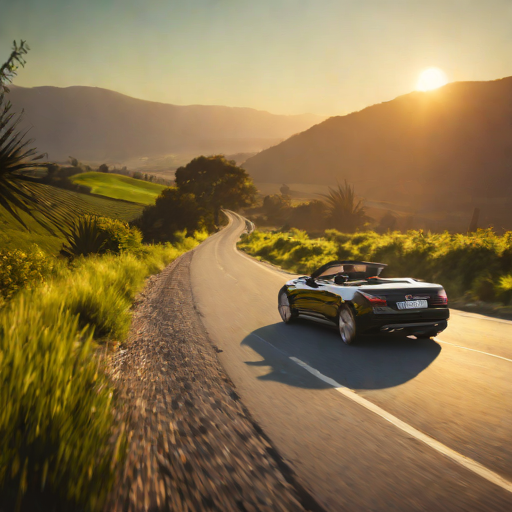

('"A stunning black convertible car cruising down the picturesque countryside '
 'highway. The sleek silhouette of the car blends beautifully into the setting '
 'sun, leaving a trail of wanderers admiring its beauty and sophistication. '
 'The soft top is folded down, letting the sweet sound of the wind and sun-in '
 'take its occupants away')


In [5]:
transformer = RenderPrompts(display_in_notebook=True)
transformer.load_model()
shards = glob.glob(f"{odir}/shuffled/*.tar")
transformer.transform_shard(shards[0], "temp.tar", maxcount=10)
del transformer

# Parallelization with Ray

For parallel rendering, we use a Ray cluster. This will also work on a single machine with just one GPU.

In [6]:
import ray

if not ray.is_initialized():
    ray.init(log_to_driver=False)

@ray.remote(num_gpus=1)
class RayRenderPrompts(RenderPrompts):
    def __init__(self):
        super().__init__()

2023-12-30 03:30:54,938	INFO worker.py:1715 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


In [7]:
# Start up and create the actor pool.
# This tries to adapt to the number of GPUs available.
# It also checks that each actor has sufficient memory.
# If not, set up your cluster differently by excluding GPUs that are too small.
# (Ray's facilities for heterogenous clusters are somewhat limited)

ngpus = get_num_gpus() if nactors == -1 else nactors

print(f"using {ngpus} actors")
actors = [RayRenderPrompts.remote() for i in range(int(ngpus))]

print("loading the models")
for actor in actors:
    assert ray.get(actor.gpu_is_sufficient.remote()), "GPU memory insufficient"
    ray.get(actor.load_model.remote())

print("creating the pool")
pool = ray.util.ActorPool(actors)

using 1.0 actors
loading the models
creating the pool


In [8]:
import glob
import os

def apply_actor(actor, action):
    src, dst = action
    print(f"START {src} -> {dst}")
    result = actor.transform_shard.remote(src, dst)
    print(f"DONE  {src} -> {dst}")
    return result

!mkdir -p $odir/images
shards = [os.path.basename(p) for p in  sorted(glob.glob(f"{odir}/shuffled/*.tar"))]
actions = [(f"{odir}/shuffled/{shard}", f"{odir}/images/{shard}") for shard in shards]
result = list(pool.map(apply_actor, actions))

START ./mini-imagenet-10/shuffled/mi10-000000.tar -> ./mini-imagenet-10/images/mi10-000000.tar
DONE  ./mini-imagenet-10/shuffled/mi10-000000.tar -> ./mini-imagenet-10/images/mi10-000000.tar
START ./mini-imagenet-10/shuffled/mi10-000001.tar -> ./mini-imagenet-10/images/mi10-000001.tar
DONE  ./mini-imagenet-10/shuffled/mi10-000001.tar -> ./mini-imagenet-10/images/mi10-000001.tar
START ./mini-imagenet-10/shuffled/mi10-000002.tar -> ./mini-imagenet-10/images/mi10-000002.tar
DONE  ./mini-imagenet-10/shuffled/mi10-000002.tar -> ./mini-imagenet-10/images/mi10-000002.tar
START ./mini-imagenet-10/shuffled/mi10-000003.tar -> ./mini-imagenet-10/images/mi10-000003.tar
DONE  ./mini-imagenet-10/shuffled/mi10-000003.tar -> ./mini-imagenet-10/images/mi10-000003.tar
START ./mini-imagenet-10/shuffled/mi10-000004.tar -> ./mini-imagenet-10/images/mi10-000004.tar
DONE  ./mini-imagenet-10/shuffled/mi10-000004.tar -> ./mini-imagenet-10/images/mi10-000004.tar
START ./mini-imagenet-10/shuffled/mi10-000005.tar 